> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - TMDb movie data

## Table of Contents
<ul>
<li><a href="#intro">1-Introduction</a></li>
<li><a href="#wrangling">2-Data Wrangling</a></li>
<li><a href="#eda">3-Exploratory Data Analysis</a></li>
<li><a href="#conclusions">4-Conclusions</a></li>
</ul>

<a id='intro'></a>
## 1-Introduction

> ### Dataset Description 

> The data set contains information about 10,000 movies collected from The Movie Database (TMDb), including user ratings and revenue.
>Data set is downloaded from : https://www.google.com/url?q=https%3A%2F%2Fd17h27t6h515a5.cloudfront.net%2Ftopher%2F2017%2FOctober%2F59dd1c4c_tmdb-movies%2Ftmdb-movies.csv&sa=D&source=docs <br>
The data set is uploaded to same directory of the notebood 

> <b>Important Data Fields:
> <p>imdb_id: movie ID<br>
> popularity: movie popularity<br>    
> budget: movie budget <br> 
> revenue : revenu <br>
> original_title : title<br> 
> cast : movie cast<br> 
> director: movie director<br> 
> release_year: release year  <br>   

### Question(s) for Analysis
> Is voting declining over the years?<br>
> Is there a relation between movie popularity and revenues?<br>
> Is crowd not interested in western movies compared to drama? What is the trend?<br>
> What is the trend of film production over time?<br>

In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [2]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0


Requirement already up-to-date: pandas==0.25.0 in /opt/conda/lib/python3.6/site-packages (0.25.0)


<a id='wrangling'></a>
## 2- Data Wrangling

## 2-1 Read Data Frame

In [3]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('tmdb-movies.csv')
df.head(5)

,id,imdb_id,popularity,budget,revenue,original_title,cast,homepage,director,tagline,...,overview,runtime,genres,production_companies,release_date,vote_count,vote_average,release_year,budget_adj,revenue_adj
0,135397,tt0369610,32.985763,150000000,1513528810,Jurassic World,Chris Pratt|Bryce Dallas Howard|Irrfan Khan|Vi...,http://www.jurassicworld.com/,Colin Trevorrow,The park is open.,...,Twenty-two years after the events of Jurassic ...,124,Action|Adventure|Science Fiction|Thriller,Universal Studios|Amblin Entertainment|Legenda...,6/9/15,5562,6.5,2015,1.379999e+08,1.392446e+09
1,76341,tt1392190,28.419936,150000000,378436354,Mad Max: Fury Road,Tom Hardy|Charlize Theron|Hugh Keays-Byrne|Nic...,http://www.madmaxmovie.com/,George Miller,What a Lovely Day.,...,An apocalyptic story set in the furthest reach...,120,Action|Adventure|Science Fiction|Thriller,Village Roadshow Pictures|Kennedy Miller Produ...,5/13/15,6185,7.1,2015,1.379999e+08,3.481613e+08
2,262500,tt2908446,13.112507,110000000,295238201,Insurgent,Shailene Woodley|Theo James|Kate Winslet|Ansel...,http://www.thedivergentseries.movie/#insurgent,Robert Schwentke,One Choice Can Destroy You,...,Beatrice Prior must confront her inner demons ...,119,Adventure|Science Fiction|Thriller,Summit Entertainment|Mandeville Films|Red Wago...,3/18/15,2480,6.3,2015,1.012000e+08,2.716190e+08
3,140607,tt2488496,11.173104,200000000,2068178225,Star Wars: The Force Awakens,Harrison Ford|Mark Hamill|Carrie Fisher|Adam D...,http://www.starwars.com/films/star-wars-episod...,J.J. Abrams,Every generation has a story.,...,Thirty years after defeating the Galactic Empi...,136,Action|Adventure|Science Fiction|Fantasy,Lucasfilm|Truenorth Productions|Bad Robot,12/15/15,5292,7.5,2015,1.839999e+08,1.902723e+09
4,168259,tt2820852,9.335014,190000000,1506249360,Furious 7,Vin Diesel|Paul Walker|Jason Statham|Michelle ...,http://www.furious7.com/,James Wan,Vengeance Hits Home,...,Deckard Shaw seeks revenge against Dominic Tor...,137,Action|Crime|Thriller,Universal Pictures|Original Film|Media Rights ...,4/1/15,2947,7.3,2015,1.747999e+08,1.385749e+09


In [4]:
#Split director column into separate columns
df_directors = df['director'].str.split('|', expand=True).rename(columns=lambda x: f"director_{x+1}")
df_directors.head(5)

,director_1,director_2,director_3,director_4,director_5,director_6,director_7,director_8,director_9,director_10,...,director_27,director_28,director_29,director_30,director_31,director_32,director_33,director_34,director_35,director_36
0,Colin Trevorrow,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,George Miller,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
2,Robert Schwentke,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
3,J.J. Abrams,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
4,James Wan,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None


> The director split ended up with 36 columns. We took decision to leave director column unchanged due to irregular split results

In [5]:
print ("Data frame shape before wrangling{}\n".format(df.shape))
print ("Data frame info and coloumn type check before wrangling{}\n".format(df.info()))

Data frame shape before wrangling(10866, 21)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            

## 2-1 Data Wrangling Function

In [6]:
def datawrangling (df):
    '''
    parameter df: Pnadas dataframe
    return df: Data Wrangled data frame
    '''
    print('Start data wrangling ....\n')
    #Drop Columns
    #From the above , certain coloumns don't add into the analayis. Therefore, we will drop those coloumns
    #“_adj” show the budget and revenue of the associated movie in terms of 2010 dollars, accounting for inflation over time. Therefore, drop budget, revenue columns
    #dropped columns: id, imdb_id, budget, revenue, homepage, tagline, overview, keywords
    df.drop(columns=['id', 'budget', 'revenue', 'homepage', 'tagline', 'overview', 'keywords'], 
            inplace=True )
    #Check null values
    #We can't fill missing values because values are stings. Therefore, drop rows with missing values.
    print('Check null values\n')
    print('Total number of rows: {}\n'.format(df.shape[0]))
    for col in df.columns:
       if df[col].isna().sum() != 0:
        print ('Column <{}> has {} null values\n'.format(col, df[col].isna().sum() ))
    df.dropna()
    
    #Remove Duplicates
    df.drop_duplicates(inplace=True)
    print ('Duplicate removed, new dataframe shape{}\n'.format(df.shape))
    
    #Change the amounts to millions in budget_adj and revenue_adj
    #create budget_adj_mil and revenue_adj_mil to adjust figures to nearst millions then drop budget_adj and revenue_adj coloumns
    print('create budget_adj_mil and revenue_adj_mil to adjust figures to nearst millions\n')
    print('create profit column\n')
    df['budget_adj_mil'] = round(df['budget_adj'] /1000000)
    df['revenue_adj_mil'] = round(df['revenue_adj'] /1000000)
    df['profit'] = df['revenue_adj_mil'] - df['budget_adj_mil']
    
    #drop budget_adj and revenue_adj columns
    print('Drop budget_adj and revenue_adj columns\n')
    df.drop(columns=['budget_adj', 'revenue_adj'], inplace=True )
    
    # Split generes into separate columns and append to main dataframe
    print ('Split generes into separate columns\n')
    df_genres = df['genres'].str.split('|', expand=True).rename(columns=lambda x: f"genre_{x+1}")
    #append splited genres
    df[df_genres.columns] = df_genres
    
    #Director split
    print('director column unchanged due to irregular split results\n')
    
    #Split cast column into separate columns
    print('Split cast column into separate columns\n')
    df_cast = df['cast'].str.split('|', expand=True).rename(columns=lambda x: f"cast_{x+1}")
    #append splited cast
    df[df_cast.columns] = df_cast
    
    print('Data wrangling ended....\n')
    
    return df
    
    

### 2.2 Call Data Wrangling

In [7]:
df= datawrangling (df)

Start data wrangling ....

Check null values

Total number of rows: 10866

Column <imdb_id> has 10 null values

Column <cast> has 76 null values

Column <director> has 44 null values

Column <genres> has 23 null values

Column <production_companies> has 1030 null values

Duplicate removed, new dataframe shape(10865, 14)

create budget_adj_mil and revenue_adj_mil to adjust figures to nearst millions

create profit column

Drop budget_adj and revenue_adj columns

Split generes into separate columns

director column unchanged due to irregular split results

Split cast column into separate columns

Data wrangling ended....



In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 25 columns):
imdb_id                 10855 non-null object
popularity              10865 non-null float64
original_title          10865 non-null object
cast                    10789 non-null object
director                10821 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null object
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj_mil          10865 non-null float64
revenue_adj_mil         10865 non-null float64
profit                  10865 non-null float64
genre_1                 10842 non-null object
genre_2                 8514 non-null object
genre_3                 5078 non-null object
genre_4                 1980 non-null object
genre_5            

### Number of records with budget equals zero

In [9]:
df[df['budget_adj_mil'] == 0]['budget_adj_mil'].value_counts()

0.0    5905
Name: budget_adj_mil, dtype: int64

The number of zero rows (5905) is about 50% and hence data quality is low. No action taken as removing  rows will affect other features

<a id='eda'></a>
## 3- Exploratory Data Analysis

### Research Question 1 (Is voting declining over the years?)

### Over all stats

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10865 entries, 0 to 10865
Data columns (total 25 columns):
imdb_id                 10855 non-null object
popularity              10865 non-null float64
original_title          10865 non-null object
cast                    10789 non-null object
director                10821 non-null object
runtime                 10865 non-null int64
genres                  10842 non-null object
production_companies    9835 non-null object
release_date            10865 non-null object
vote_count              10865 non-null int64
vote_average            10865 non-null float64
release_year            10865 non-null int64
budget_adj_mil          10865 non-null float64
revenue_adj_mil         10865 non-null float64
profit                  10865 non-null float64
genre_1                 10842 non-null object
genre_2                 8514 non-null object
genre_3                 5078 non-null object
genre_4                 1980 non-null object
genre_5            

In [11]:
#All time high revenu 
df.sort_values(by='revenue_adj_mil', ascending=False)
print('Movie {} is highest revenue of {} millions'.format(df['original_title'].iloc[0], df['revenue_adj_mil'].iloc[0]))
#Most popular movie
df.sort_values(by='popularity', ascending=False)
print('Movie {} is most popular movie'.format(df['original_title'].iloc[0]))


Movie Jurassic World is highest revenue of 1392.0 millions
Movie Jurassic World is most popular movie


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fb05627a0f0>,
      dtype=object)

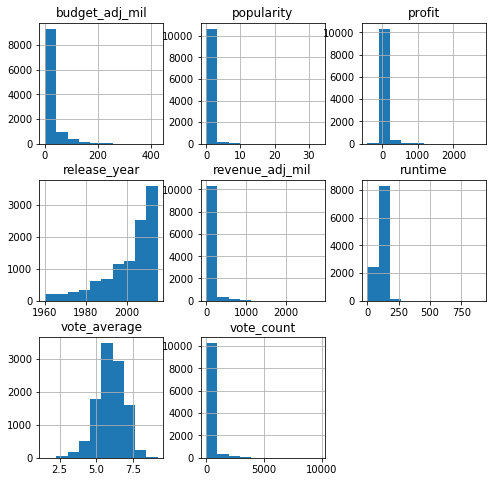

In [12]:
df.hist(figsize=(8,8))

Text(0.5,1,'Voting trend over years')

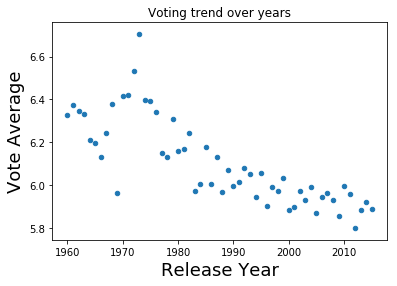

In [13]:

vote_rate = pd.DataFrame(df.groupby('release_year')['vote_average'].mean().reset_index())
vote_rate.plot(kind='scatter', x='release_year', y='vote_average') #title='Average Wine Quality by Color', color=colors, alpha=.7);
plt.xlabel('Release Year', fontsize=18)
plt.ylabel('Vote Average', fontsize=18)
plt.title('Voting trend over years')


The output from describe states that there is an issue with min vlaues for runtime (0) and vote_average (1.5) nad 

### Discover outliers in voting average

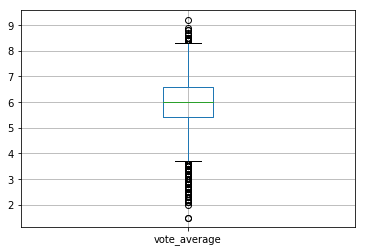

In [14]:
boxplot = df.boxplot(column=['vote_average'])  

### Discover correlation with different features

In [15]:
df.corr()

,popularity,runtime,vote_count,vote_average,release_year,budget_adj_mil,revenue_adj_mil,profit
popularity,1.000000,0.139032,0.800828,0.209517,0.089806,0.513624,0.609090,0.562832
runtime,0.139032,1.000000,0.163273,0.156813,-0.117187,0.221092,0.175657,0.142329
vote_count,0.800828,0.163273,1.000000,0.253818,0.107962,0.587069,0.707949,0.656901
vote_average,0.209517,0.156813,0.253818,1.000000,-0.117576,0.093070,0.193059,0.197498
release_year,0.089806,-0.117187,0.107962,-0.117576,1.000000,0.016791,-0.066246,-0.081118
budget_adj_mil,0.513624,0.221092,0.587069,0.093070,0.016791,1.000000,0.646615,0.472939
revenue_adj_mil,0.609090,0.175657,0.707949,0.193059,-0.066246,0.646615,1.000000,0.977923
profit,0.562832,0.142329,0.656901,0.197498,-0.081118,0.472939,0.977923,1.000000


### Research Question 2  (Is there a relation between movie popularity and revenues?)

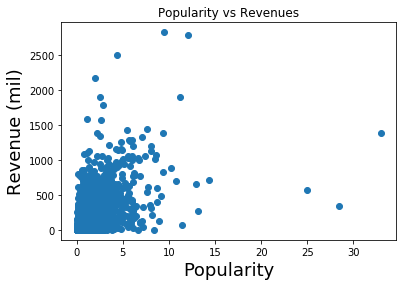

In [16]:
plt.scatter(df['popularity'], df['revenue_adj_mil'])
plt.title('Popularity vs Revenues')
plt.xlabel('Popularity', fontsize=18)
plt.ylabel('Revenue (mil)', fontsize=18)
plt.show()


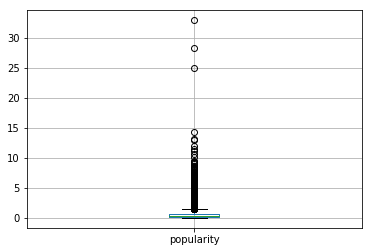

In [17]:
boxplot = df.boxplot(column=['popularity'])  

In [18]:
df['popularity'].describe()

count    10865.000000
mean         0.646446
std          1.000231
min          0.000065
25%          0.207575
50%          0.383831
75%          0.713857
max         32.985763
Name: popularity, dtype: float64

### Research Question 3  (Is crowd not interested in western movies compared to drama? What is the trend?)
> we will use first genere to construct our analysis

In [19]:
t= pd.DataFrame(df.groupby(['release_year', 'genre_1']).agg({'genre_1': ['count']}).reset_index())
#create flat level index
drama= pd.DataFrame()
drama['year'] = t[t[('genre_1', '')] == 'Drama'] [('release_year',      '')]
drama['genre'] = t[t[('genre_1', '')] == 'Drama'] [(     'genre_1',      '')]
drama['count'] = t[t[('genre_1', '')] == 'Drama'] [(     'genre_1', 'count')]
print(t.columns)
drama.head()

MultiIndex([('release_year',      ''),
            (     'genre_1',      ''),
            (     'genre_1', 'count')],
           )


,year,genre,count
4,1960,Drama,5
10,1961,Drama,7
21,1962,Drama,11
31,1963,Drama,7
40,1964,Drama,10


In [20]:
#Western
western= pd.DataFrame()
western['year'] = t[t[('genre_1', '')] == 'Western'] [('release_year',      '')]
western['genre'] = t[t[('genre_1', '')] == 'Western'] [(     'genre_1',      '')]
western['count'] = t[t[('genre_1', '')] == 'Western'] [(     'genre_1', 'count')]
print(t.columns)
western.head()

MultiIndex([('release_year',      ''),
            (     'genre_1',      ''),
            (     'genre_1', 'count')],
           )


,year,genre,count
16,1961,Western,3
26,1962,Western,2
45,1964,Western,1
68,1966,Western,2
82,1967,Western,1


Text(0.5,1,'Drama trend over the years')

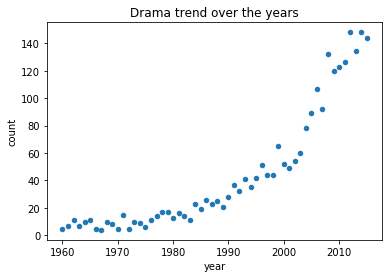

In [21]:
d = pd.DataFrame(drama.groupby('year')['count'].sum().reset_index())
d.plot(kind='scatter', x='year', y='count') 
plt.title('Drama trend over the years')

Text(0.5,1,'Western trend over the years')

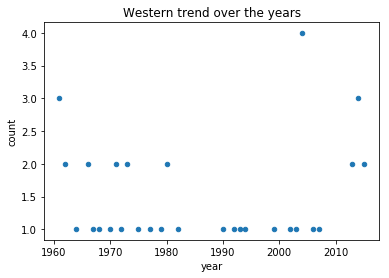

In [22]:
w = pd.DataFrame(western.groupby('year')['count'].sum().reset_index())
w.plot(kind='scatter', x='year', y='count') 
#plt.xlabel('Release Year', fontsize=18)
#plt.ylabel('Vote Average', fontsize=18)
plt.title('Western trend over the years')

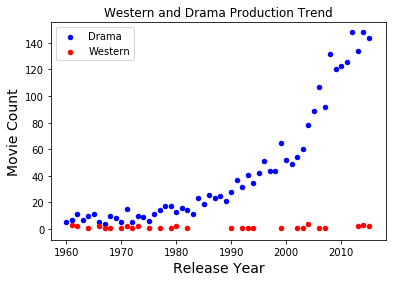

In [29]:
fig, ax = plt.subplots()
d.plot.scatter(x = 'year', y = 'count', color=['blue'], ax=ax)
w.plot.scatter(x = 'year', y = 'count', color=['red'], ax=ax)
plt.title('Western and Drama Production Trend')
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Movie Count', fontsize=14)
ax.legend(['Drama', 'Western'])
plt.show()

### Research Question 4 (What is the trend of film production over time?)

Text(0.5,1,'Overall Film Production Trend')

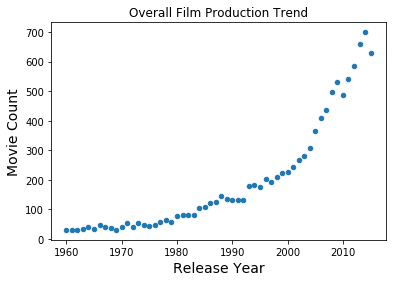

In [30]:
production_rate = pd.DataFrame(df.groupby('release_year')['imdb_id'].count().reset_index())
production_rate.plot(kind='scatter', x='release_year', y='imdb_id') #title='Average Wine Quality by Color', color=colors, alpha=.7);
plt.xlabel('Release Year', fontsize=14)
plt.ylabel('Movie Count', fontsize=14)
plt.title('Overall Film Production Trend')

<a id='conclusions'></a>
## Conclusions

> <b> Research Question 1: (Is voting declining over the years?)<br>
> <p>Advances in technologies gave viewers the ability to vote easily. Surprisingly, the voting count trend is declining.

> Research Question 2: (Is there a relation between movie popularity and revenues?) <br>
> <p>It seems logical to see strong correlation between popularity and revenues that was reflected in the correlation table and scatter diagram.

> <b> Research Question 3: (Is crowd not interested in western movies compared to drama? What is the trend?<br>
> <p>Movies consist of a combination of genres, but there is a dominant genre. For this research we used first research as the dominant genres. 
Viewers' demand for western movies are declining in comparison to drama movies.

> <b> Research Question 4: (What is the trend of film production over time?)<br>
> <p>The graph shows a positive trend and exponential increase in movie production over the years.
Advances in technologies are the primary factor in reducing production time and hence increasing the number of movies per year.

> <b> Data set notes:<br>
> <p>The data set contains various cells with zero values that require domain expertise to help in filling the gap.
Therefore, the boxplot shows outliers in various features such as :
Max popularity and runtime of 32.985763 and 900 respectively.

>The number of zero rows (5905) is about 50% and hence data quality is low. Histogram of various features are skewed to right and start at zero due to zero values inside data set
No action taken as removing rows will affect other features.



## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [31]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0